In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Install necessary libraries if not available
!pip install -q torch torchvision matplotlib scikit-learn

# Import necessary libraries
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import os
from torchvision import models, datasets
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns


In [3]:
# Define transformations for image augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.RandomHorizontalFlip(),  # Augmentation
    transforms.RandomRotation(20),
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Define dataset path
data_path = "/kaggle/input/plantvillage-dataset/color/"  # Update if needed

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=data_path, transform=transform)

# Split dataset into train, validation, and test (60-20-20)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [4]:
model = models.vit_b_16(weights=models.ViT_B_16_Weights.IMAGENET1K_V1)

num_ftrs = model.heads.head.in_features
num_classes = 38

model.heads.head = nn.Linear(num_ftrs, num_classes)

for param in model.encoder.parameters():
    param.requires_grad = False

for param in model.heads.parameters():
    param.requires_grad = True


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 218MB/s]


In [5]:
torch.save(model.state_dict() , "efficient_model.pth")

In [6]:
num_epochs = 4  # You can increase this for better accuracy
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    
    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(val_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}")


Epoch 1/4, Training Loss: 0.8837, Validation Loss: 0.4230
Epoch 2/4, Training Loss: 0.3439, Validation Loss: 0.2600
Epoch 3/4, Training Loss: 0.2544, Validation Loss: 0.2713
Epoch 4/4, Training Loss: 0.2336, Validation Loss: 0.2064


In [7]:
# Test model and compute accuracy
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 92.94%


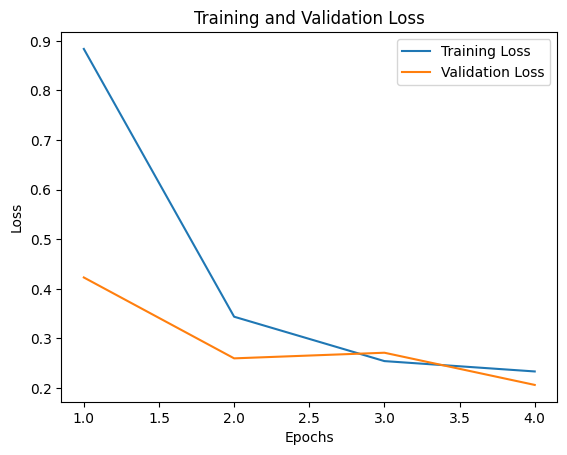

In [8]:
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.savefig("loss_curve.png")
plt.show()


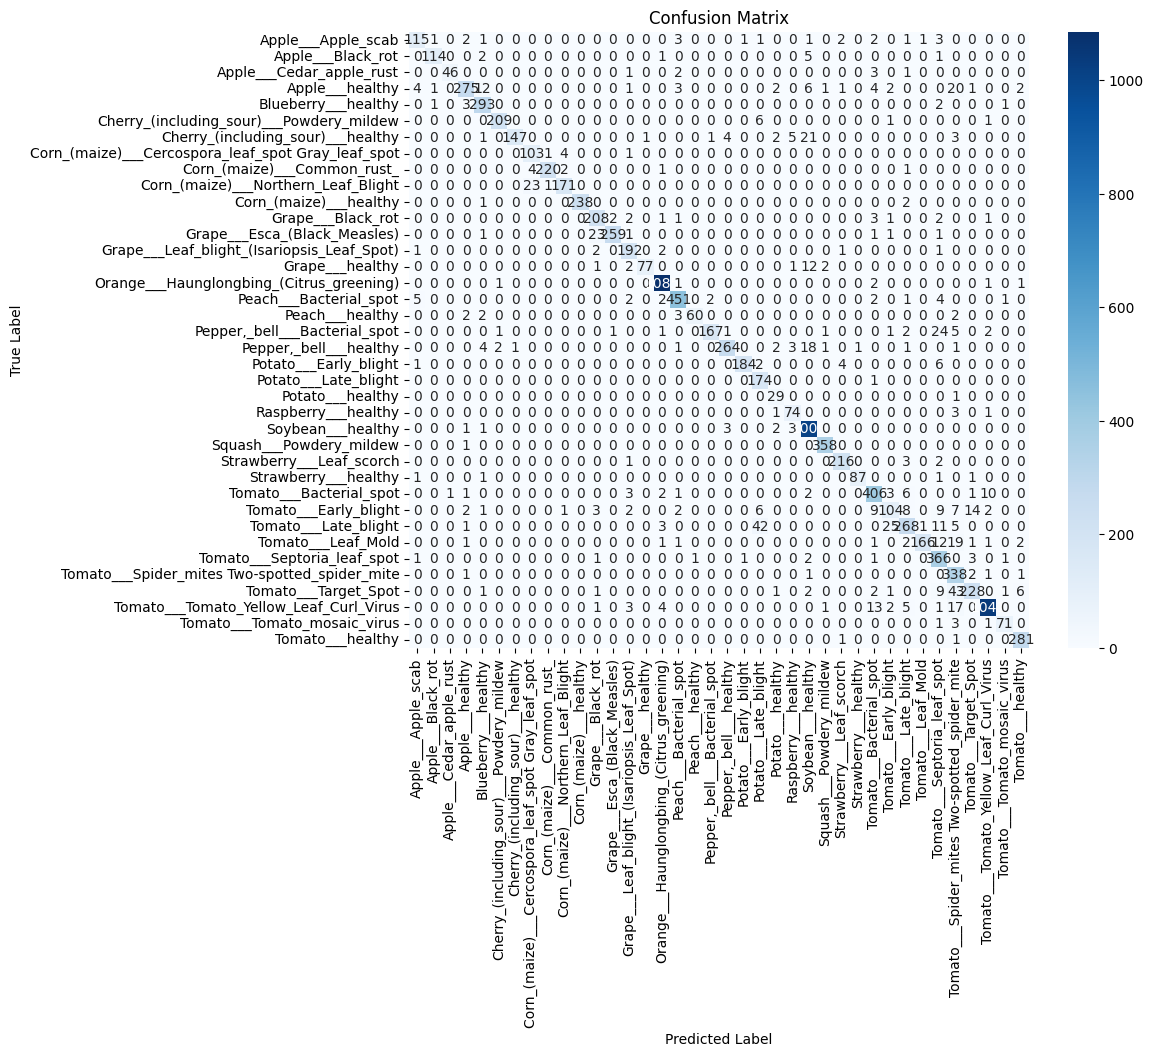

In [9]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.savefig("confusion_matrix.png")
plt.show()


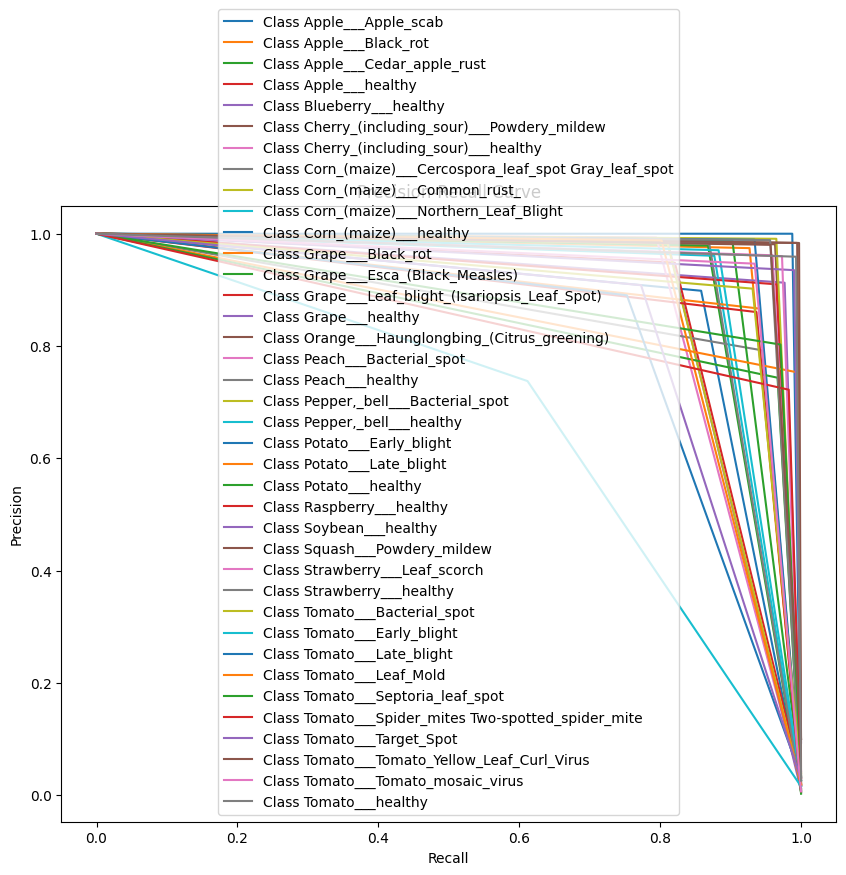

In [10]:
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(all_labels, classes=list(range(num_classes)))
y_pred_bin = label_binarize(all_preds, classes=list(range(num_classes)))

plt.figure(figsize=(10, 8))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_bin[:, i])
    plt.plot(recall, precision, label=f'Class {dataset.classes[i]}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig("pr_curve.png")
plt.show()
